In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

### Data preparation, Data partitioning and normalization

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']

In [4]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [5]:
from data_preparation import prepare_dataset

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Day,Hour,Occupancy
0,23.18,27.2720,426.0,721.25,2,17,1
1,23.15,27.2675,429.5,714.00,2,17,1
2,23.15,27.2450,426.0,713.50,2,17,1
3,23.15,27.2000,426.0,708.25,2,17,1
4,23.10,27.2000,426.0,704.50,2,17,1


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Single layer network

In [11]:
from sklearn.linear_model import Perceptron

In [12]:
sln=Perceptron()

In [13]:
sln.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
y_pred_sln = sln.predict(X_test)

In [15]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_sln))
print('F1-score %s' % f1_score(y_test, y_pred_sln, average=None))
print(classification_report(y_test, y_pred_sln))

Accuracy 0.9854085603112841
F1-score [0.99049028 0.96866295]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.96      0.98      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.98      0.98      6168
weighted avg       0.99      0.99      0.99      6168



non posso fare roc curve ne lift chart perchè questo classificatore non ha clf.proba (Perceptrons do not output a class probability; rather,
they just make predictions based on a hard threshold. This is one of the good reasons to prefer Logistic
Regression over Perceptrons.)


## Multiple layer network

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
mln = MLPClassifier(random_state=0)

mln.fit(X_train, y_train)

y_pred_mln = mln.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_mln))
print('F1-score %s' % f1_score(y_test, y_pred_mln, average=None))
print(classification_report(y_test, y_pred_mln))

Accuracy 0.9920557717250325
F1-score [0.99481317 0.98303911]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



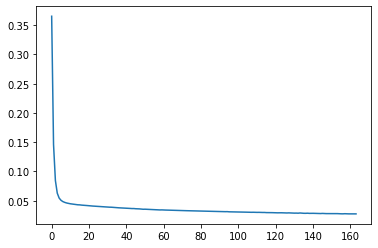

In [18]:
plt.plot(mln.loss_curve_)
plt.show()

non sembrano esserci problemi ne di overfitting ne di underfitting:
    - overfitting: The plot of training loss continues to decrease with experience or The plot of validation loss decreases to a point and begins increasing again.
    - underfitting:The training loss remains flat regardless of training or The training loss continues to decrease until the end of training.

This example visualizes some training loss curves for different stochastic learning strategies, including SGD and Adam. 

In [19]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.769, 5.606281


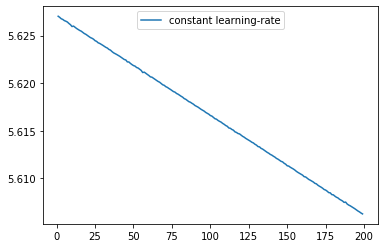

constant with momentum
training set score and loss: 0.769, 488.868846


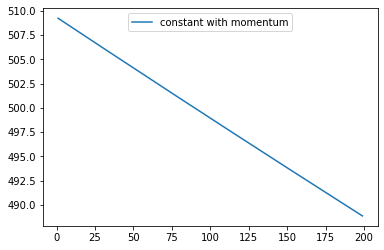

constant with Nesterov's momentum
training set score and loss: 0.769, 1603.213153


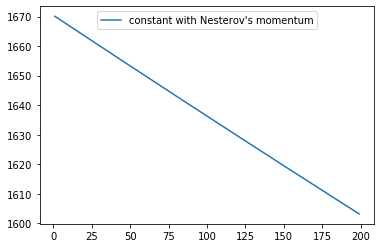

inv-scaling learning-rate
training set score and loss: 0.769, 5.627009


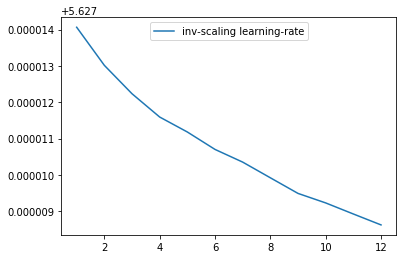

inv-scaling with momentum
training set score and loss: 0.769, 1670.178766


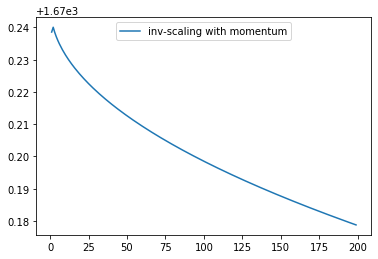

inv-scaling with Nesterov's momentum
training set score and loss: 0.769, 509.280629


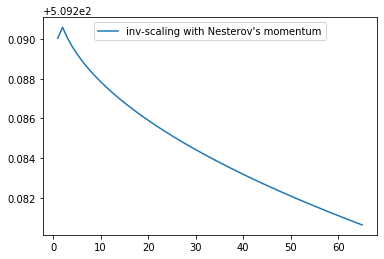

adam
training set score and loss: 0.990, 0.051007


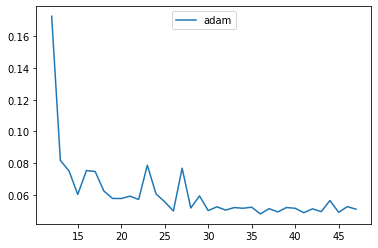

In [21]:
for label, param in zip(labels, params):
    print(label)
    mlp = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X, y)

    print("training set score and loss: %.3f, %f" % (mlp.score(X, y), mlp.loss_))
    plt.plot(mlp.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

 le strategie portano ad overfitting: le prime sei perche la loss curve continuano a decrescere con l'esperienza

## keras DNN

In [19]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [54]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(6, input_dim=n_feature, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

-The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.(The batch size is a number of samples processed before the model is updated)


-The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.(The number of epochs is the number of complete passes through the training dataset)

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [55]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=100, batch_size=30).history

Epoch 1/100
11513/11513 [==============================] - 3s 266us/step - loss: 0.1927 - accuracy: 0.9222
Epoch 2/100
11513/11513 [==============================] - 2s 169us/step - loss: 0.0503 - accuracy: 0.9885
Epoch 3/100
11513/11513 [==============================] - 2s 169us/step - loss: 0.0449 - accuracy: 0.9894
Epoch 4/100
11513/11513 [==============================] - 2s 167us/step - loss: 0.0429 - accuracy: 0.9895
Epoch 5/100
11513/11513 [==============================] - 2s 164us/step - loss: 0.0418 - accuracy: 0.9895
Epoch 6/100
11513/11513 [==============================] - 2s 166us/step - loss: 0.0411 - accuracy: 0.9896
Epoch 7/100
11513/11513 [==============================] - 2s 183us/step - loss: 0.0407 - accuracy: 0.9896
Epoch 8/100
11513/11513 [==============================] - 2s 184us/step - loss: 0.0403 - accuracy: 0.9895
Epoch 9/100
11513/11513 [==============================] - 2s 191us/step - loss: 0.0396 - accuracy: 0.9895
Epoch 10/100
11513/11513 [===========

11513/11513 [==============================] - 2s 160us/step - loss: 0.0283 - accuracy: 0.9910
Epoch 77/100
11513/11513 [==============================] - 2s 149us/step - loss: 0.0274 - accuracy: 0.9916
Epoch 78/100
11513/11513 [==============================] - 2s 150us/step - loss: 0.0276 - accuracy: 0.9910
Epoch 79/100
11513/11513 [==============================] - 2s 164us/step - loss: 0.0276 - accuracy: 0.9911
Epoch 80/100
11513/11513 [==============================] - 2s 165us/step - loss: 0.0269 - accuracy: 0.9915
Epoch 81/100
11513/11513 [==============================] - 2s 164us/step - loss: 0.0274 - accuracy: 0.9917
Epoch 82/100
11513/11513 [==============================] - 2s 165us/step - loss: 0.0275 - accuracy: 0.9914
Epoch 83/100
11513/11513 [==============================] - 2s 165us/step - loss: 0.0270 - accuracy: 0.9914
Epoch 84/100
11513/11513 [==============================] - 2s 173us/step - loss: 0.0275 - accuracy: 0.9910
Epoch 85/100
11513/11513 [===============

In [56]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=100).history

Epoch 1/100
11513/11513 [==============================] - 2s 143us/step - loss: 0.4294 - accuracy: 0.8307
Epoch 2/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.1042 - accuracy: 0.9675
Epoch 3/100
11513/11513 [==============================] - 1s 54us/step - loss: 0.0522 - accuracy: 0.9875
Epoch 4/100
11513/11513 [==============================] - 1s 54us/step - loss: 0.0459 - accuracy: 0.9888
Epoch 5/100
11513/11513 [==============================] - 1s 57us/step - loss: 0.0435 - accuracy: 0.9891
Epoch 6/100
11513/11513 [==============================] - 1s 52us/step - loss: 0.0425 - accuracy: 0.9892
Epoch 7/100
11513/11513 [==============================] - 1s 52us/step - loss: 0.0419 - accuracy: 0.9893
Epoch 8/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0413 - accuracy: 0.9894
Epoch 9/100
11513/11513 [==============================] - 1s 61us/step - loss: 0.0414 - accuracy: 0.9891
Epoch 10/100
11513/11513 [===================

11513/11513 [==============================] - 1s 54us/step - loss: 0.0280 - accuracy: 0.9915
Epoch 77/100
11513/11513 [==============================] - 1s 54us/step - loss: 0.0277 - accuracy: 0.9912
Epoch 78/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0278 - accuracy: 0.9911
Epoch 79/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0276 - accuracy: 0.9912
Epoch 80/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0284 - accuracy: 0.9908
Epoch 81/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0276 - accuracy: 0.9911
Epoch 82/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0271 - accuracy: 0.9916
Epoch 83/100
11513/11513 [==============================] - 1s 53us/step - loss: 0.0272 - accuracy: 0.9916
Epoch 84/100
11513/11513 [==============================] - 1s 52us/step - loss: 0.0266 - accuracy: 0.9911
Epoch 85/100
11513/11513 [========================

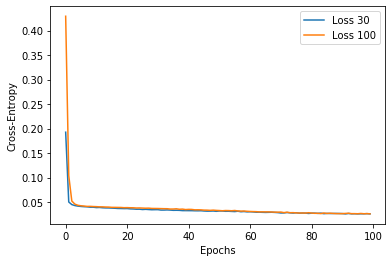

In [57]:
plt.plot(history1['loss'], label='Loss 30')
plt.plot(history2['loss'], label='Loss 100')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [58]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 1s 206us/step
Loss 0.030480, Accuracy 0.991407
Loss 0.030223, Accuracy 0.992866


In [59]:
y_pred = model2.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7689688715953308
F1-score [0.86939786 0.        ]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       0.00      0.00      0.00      1425

    accuracy                           0.77      6168
   macro avg       0.38      0.50      0.43      6168
weighted avg       0.59      0.77      0.67      6168



C:\Users\Gianmarco\anaconda3\envs\tfk\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [61]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=100).history

Train on 9210 samples, validate on 2303 samples
Epoch 1/200
9210/9210 [==============================] - 2s 249us/step - loss: 0.4148 - accuracy: 0.8289 - val_loss: 0.2023 - val_accuracy: 0.9570
Epoch 2/200
9210/9210 [==============================] - 1s 66us/step - loss: 0.1232 - accuracy: 0.9679 - val_loss: 0.0835 - val_accuracy: 0.9731
Epoch 3/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0609 - val_accuracy: 0.9792
Epoch 4/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0538 - accuracy: 0.9848 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 5/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0484 - accuracy: 0.9877 - val_loss: 0.0485 - val_accuracy: 0.9878
Epoch 6/200
9210/9210 [==============================] - 1s 71us/step - loss: 0.0468 - accuracy: 0.9884 - val_loss: 0.0472 - val_accuracy: 0.9878
Epoch 7/200
9210/9210 [==============================] - 1s 76us/step - los

9210/9210 [==============================] - 1s 64us/step - loss: 0.0371 - accuracy: 0.9895 - val_loss: 0.0503 - val_accuracy: 0.9900
Epoch 57/200
9210/9210 [==============================] - 1s 60us/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.0500 - val_accuracy: 0.9900
Epoch 58/200
9210/9210 [==============================] - 1s 70us/step - loss: 0.0368 - accuracy: 0.9893 - val_loss: 0.0499 - val_accuracy: 0.9900
Epoch 59/200
9210/9210 [==============================] - 1s 68us/step - loss: 0.0370 - accuracy: 0.9897 - val_loss: 0.0496 - val_accuracy: 0.9900
Epoch 60/200
9210/9210 [==============================] - 1s 66us/step - loss: 0.0365 - accuracy: 0.9896 - val_loss: 0.0505 - val_accuracy: 0.9900
Epoch 61/200
9210/9210 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.98 - 1s 64us/step - loss: 0.0364 - accuracy: 0.9896 - val_loss: 0.0500 - val_accuracy: 0.9900
Epoch 62/200
9210/9210 [==============================] - 1s 63us/step - loss: 0.0359 - a

9210/9210 [==============================] - 1s 59us/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0.0637 - val_accuracy: 0.9896
Epoch 112/200
9210/9210 [==============================] - 1s 59us/step - loss: 0.0299 - accuracy: 0.9913 - val_loss: 0.0636 - val_accuracy: 0.9904
Epoch 113/200
9210/9210 [==============================] - 1s 67us/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 0.0652 - val_accuracy: 0.9909
Epoch 114/200
9210/9210 [==============================] - 1s 70us/step - loss: 0.0293 - accuracy: 0.9919 - val_loss: 0.0659 - val_accuracy: 0.9896
Epoch 115/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0291 - accuracy: 0.9916 - val_loss: 0.0664 - val_accuracy: 0.9900
Epoch 116/200
9210/9210 [==============================] - 1s 64us/step - loss: 0.0302 - accuracy: 0.9911 - val_loss: 0.0660 - val_accuracy: 0.9900
Epoch 117/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0282 - accuracy: 0.9920 - val_loss: 0.0709 -

9210/9210 [==============================] - 1s 58us/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0853 - val_accuracy: 0.9891
Epoch 167/200
9210/9210 [==============================] - 1s 58us/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 0.0835 - val_accuracy: 0.9904
Epoch 168/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.0852 - val_accuracy: 0.9909
Epoch 169/200
9210/9210 [==============================] - 1s 69us/step - loss: 0.0258 - accuracy: 0.9921 - val_loss: 0.0875 - val_accuracy: 0.9909
Epoch 170/200
9210/9210 [==============================] - 1s 69us/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.0880 - val_accuracy: 0.9891
Epoch 171/200
9210/9210 [==============================] - 1s 65us/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 0.0862 - val_accuracy: 0.9904
Epoch 172/200
9210/9210 [==============================] - 1s 64us/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0854 -

In [62]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

6168/6168 [==============================] - 1s 95us/step
Loss 0.030480, Accuracy 0.991407
Loss 0.030223, Accuracy 0.992866
Loss 0.051956, Accuracy 0.992218


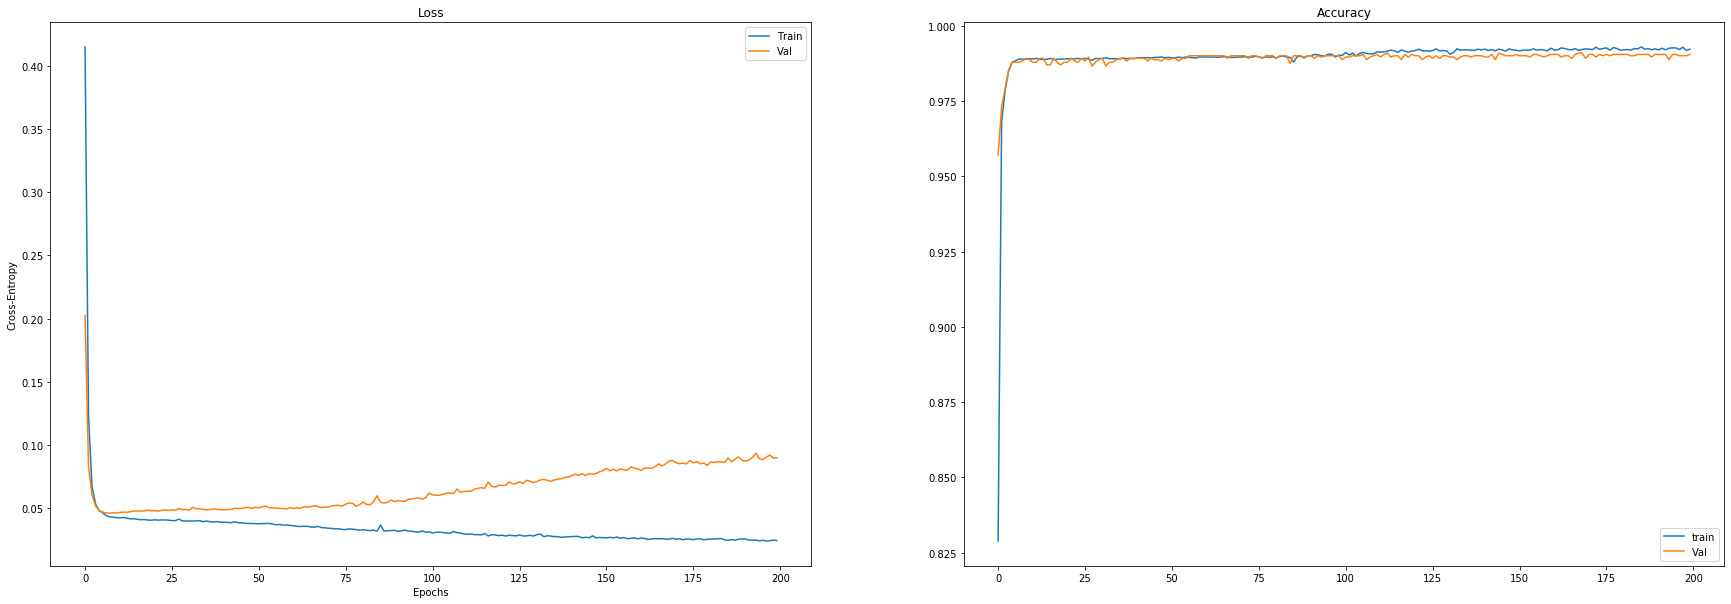

In [63]:
fig = plt.figure(figsize=(30, 10)) 
fig_dims = (1, 2)

#plot loss during training
plt.subplot2grid(fig_dims, (0, 0))
plt.title('Loss')
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
#plt.show()

# plot accuracy during training
plt.subplot2grid(fig_dims, (0,1))
plt.title('Accuracy')
plt.plot(history3['accuracy'], label='train')
plt.plot(history3['val_accuracy'], label='Val')
plt.legend()
#plt.show()

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

## Early stopping

In [64]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, 
                      batch_size=100, callbacks=[es,mc]).history

Train on 9210 samples, validate on 2303 samples
Epoch 1/200
9210/9210 [==============================] - 2s 265us/step - loss: 0.5138 - accuracy: 0.7671 - val_loss: 0.3134 - val_accuracy: 0.8567
Epoch 2/200
9210/9210 [==============================] - 1s 68us/step - loss: 0.1685 - accuracy: 0.9450 - val_loss: 0.0697 - val_accuracy: 0.9822
Epoch 3/200
9210/9210 [==============================] - 1s 66us/step - loss: 0.0608 - accuracy: 0.9862 - val_loss: 0.0454 - val_accuracy: 0.9896
Epoch 4/200
9210/9210 [==============================] - 1s 70us/step - loss: 0.0513 - accuracy: 0.9890 - val_loss: 0.0426 - val_accuracy: 0.9896
Epoch 5/200
9210/9210 [==============================] - 1s 72us/step - loss: 0.0487 - accuracy: 0.9889 - val_loss: 0.0412 - val_accuracy: 0.9900
Epoch 6/200
9210/9210 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.98 - 1s 72us/step - loss: 0.0470 - accuracy: 0.9893 - val_loss: 0.0408 - val_accuracy: 0.9904
Epoch 7/200
9210/9210 [==========

In [74]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)


print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 1s 141us/step
Loss 0.034830, Accuracy 0.990597


## L2 regularization

In [68]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [69]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, 
                    batch_size=100, callbacks=[es,mc]).history

Train on 9210 samples, validate on 2303 samples
Epoch 1/200
9210/9210 [==============================] - 3s 294us/step - loss: 5.1091 - accuracy: 0.7683 - val_loss: 3.9246 - val_accuracy: 0.7794
Epoch 2/200
9210/9210 [==============================] - 1s 86us/step - loss: 3.7961 - accuracy: 0.7684 - val_loss: 3.4624 - val_accuracy: 0.7794
Epoch 3/200
9210/9210 [==============================] - 1s 81us/step - loss: 3.5954 - accuracy: 0.7684 - val_loss: 3.4074 - val_accuracy: 0.7794
Epoch 4/200
9210/9210 [==============================] - 1s 85us/step - loss: 3.5742 - accuracy: 0.7684 - val_loss: 3.4028 - val_accuracy: 0.7794
Epoch 5/200
9210/9210 [==============================] - 1s 88us/step - loss: 3.5725 - accuracy: 0.7684 - val_loss: 3.4025 - val_accuracy: 0.7794
Epoch 6/200
9210/9210 [==============================] - 1s 79us/step - loss: 3.5724 - accuracy: 0.7684 - val_loss: 3.4025 - val_accuracy: 0.7794
Epoch 7/200
9210/9210 [==============================] - 1s 79us/step - los

In [70]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [71]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=200, batch_size=100, callbacks=[es,mc]).history

Train on 9210 samples, validate on 2303 samples
Epoch 1/200
9210/9210 [==============================] - 3s 365us/step - loss: 0.2024 - accuracy: 0.6085 - val_loss: 0.1423 - val_accuracy: 0.1146
Epoch 2/200
9210/9210 [==============================] - 1s 118us/step - loss: 0.1546 - accuracy: 0.2166 - val_loss: 0.1357 - val_accuracy: 0.0877
Epoch 3/200
9210/9210 [==============================] - 1s 111us/step - loss: 0.1492 - accuracy: 0.1227 - val_loss: 0.1479 - val_accuracy: 0.0321
Epoch 4/200
9210/9210 [==============================] - 1s 100us/step - loss: 0.1526 - accuracy: 0.0813 - val_loss: 0.1529 - val_accuracy: 0.0161
Epoch 5/200
9210/9210 [==============================] - 1s 100us/step - loss: 0.1548 - accuracy: 0.0605 - val_loss: 0.1487 - val_accuracy: 0.0200
Epoch 6/200
9210/9210 [==============================] - 1s 98us/step - loss: 0.1503 - accuracy: 0.0623 - val_loss: 0.1527 - val_accuracy: 0.0122
Epoch 7/200
9210/9210 [==============================] - 1s 102us/step 

In [72]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

6168/6168 [==============================] - 2s 282us/step


In [73]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.034522, Accuracy 0.991569
Loss 3.563643, Accuracy 0.768969
Loss 0.119955, Accuracy 0.091926


## Hyper-Parameter Tuning

In [40]:
from keras.wrappers.scikit_learn import KerasRegressor #which implements the Scikit-Learn regressor interface
from sklearn.model_selection import RandomizedSearchCV

In [43]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [44]:
n_layers = [1, 2, 3,4]
h_dim = [16,32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [45]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=200, batch_size=100, verbose=0)

3837/3837 [==============================] - 1s 219us/step


In [47]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.066807 using {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
0.097007 (0.030535) with: {'optimizer': 'adam', 'n_layers': 4, 'h_dim': 16, 'activation': 'relu'}
0.163097 (0.021344) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 128, 'activation': 'tanh'}
0.088607 (0.035214) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 64, 'activation': 'relu'}
0.119686 (0.016926) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 32, 'activation': 'relu'}
0.066807 (0.015376) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}


In [48]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

6168/6168 [==============================] - 1s 179us/step
Loss 0.062686, Accuracy 0.393158


https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53

In [49]:
def build_best_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(1, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
    return model

In [50]:
model_best = build_best_model()

history3 = model_best.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=100).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/200
11513/11513 [==============================] - 2s 181us/step - loss: 0.5452 - accuracy: 0.7693 - val_loss: 0.5035 - val_accuracy: 0.7624
Epoch 2/200
11513/11513 [==============================] - 1s 57us/step - loss: 0.4635 - accuracy: 0.7706 - val_loss: 0.4533 - val_accuracy: 0.7624
Epoch 3/200
11513/11513 [==============================] - 1s 56us/step - loss: 0.4234 - accuracy: 0.7706 - val_loss: 0.4225 - val_accuracy: 0.7624
Epoch 4/200
11513/11513 [==============================] - 1s 59us/step - loss: 0.3986 - accuracy: 0.7706 - val_loss: 0.4023 - val_accuracy: 0.7624
Epoch 5/200
11513/11513 [==============================] - 1s 50us/step - loss: 0.3809 - accuracy: 0.7706 - val_loss: 0.3869 - val_accuracy: 0.7624
Epoch 6/200
11513/11513 [==============================] - 1s 52us/step - loss: 0.3677 - accuracy: 0.7706 - val_loss: 0.3753 - val_accuracy: 0.7624
Epoch 7/200
11513/11513 [==============================] - 1s 

11513/11513 [==============================] - 1s 58us/step - loss: 0.1391 - accuracy: 0.9623 - val_loss: 0.1445 - val_accuracy: 0.9601
Epoch 56/200
11513/11513 [==============================] - 1s 63us/step - loss: 0.1377 - accuracy: 0.9627 - val_loss: 0.1431 - val_accuracy: 0.9601
Epoch 57/200
11513/11513 [==============================] - 1s 65us/step - loss: 0.1364 - accuracy: 0.9632 - val_loss: 0.1418 - val_accuracy: 0.9608
Epoch 58/200
11513/11513 [==============================] - 1s 69us/step - loss: 0.1352 - accuracy: 0.9639 - val_loss: 0.1404 - val_accuracy: 0.9611
Epoch 59/200
11513/11513 [==============================] - 1s 64us/step - loss: 0.1338 - accuracy: 0.9642 - val_loss: 0.1391 - val_accuracy: 0.9614
Epoch 60/200
11513/11513 [==============================] - 1s 54us/step - loss: 0.1325 - accuracy: 0.9643 - val_loss: 0.1379 - val_accuracy: 0.9618
Epoch 61/200
11513/11513 [==============================] - 1s 50us/step - loss: 0.1313 - accuracy: 0.9648 - val_loss: 

11513/11513 [==============================] - 1s 52us/step - loss: 0.0804 - accuracy: 0.9886 - val_loss: 0.0826 - val_accuracy: 0.9878
Epoch 111/200
11513/11513 [==============================] - 1s 58us/step - loss: 0.0797 - accuracy: 0.9889 - val_loss: 0.0819 - val_accuracy: 0.9878
Epoch 112/200
11513/11513 [==============================] - 1s 57us/step - loss: 0.0791 - accuracy: 0.9891 - val_loss: 0.0812 - val_accuracy: 0.9878
Epoch 113/200
11513/11513 [==============================] - 1s 54us/step - loss: 0.0785 - accuracy: 0.9892 - val_loss: 0.0806 - val_accuracy: 0.9882
Epoch 114/200
11513/11513 [==============================] - 1s 52us/step - loss: 0.0780 - accuracy: 0.9893 - val_loss: 0.0800 - val_accuracy: 0.9889
Epoch 115/200
11513/11513 [==============================] - 1s 46us/step - loss: 0.0775 - accuracy: 0.9893 - val_loss: 0.0795 - val_accuracy: 0.9889
Epoch 116/200
11513/11513 [==============================] - 1s 54us/step - loss: 0.0770 - accuracy: 0.9894 - val_

Epoch 165/200
11513/11513 [==============================] - 1s 51us/step - loss: 0.0637 - accuracy: 0.9895 - val_loss: 0.0649 - val_accuracy: 0.9889
Epoch 166/200
11513/11513 [==============================] - 1s 49us/step - loss: 0.0635 - accuracy: 0.9895 - val_loss: 0.0647 - val_accuracy: 0.9889
Epoch 167/200
11513/11513 [==============================] - 1s 51us/step - loss: 0.0633 - accuracy: 0.9895 - val_loss: 0.0645 - val_accuracy: 0.9889
Epoch 168/200
11513/11513 [==============================] - 1s 51us/step - loss: 0.0632 - accuracy: 0.9895 - val_loss: 0.0644 - val_accuracy: 0.9889
Epoch 169/200
11513/11513 [==============================] - 1s 50us/step - loss: 0.0630 - accuracy: 0.9895 - val_loss: 0.0642 - val_accuracy: 0.9889
Epoch 170/200
11513/11513 [==============================] - 1s 50us/step - loss: 0.0629 - accuracy: 0.9895 - val_loss: 0.0641 - val_accuracy: 0.9889
Epoch 171/200
11513/11513 [==============================] - 1s 49us/step - loss: 0.0627 - accuracy:

In [51]:
test_loss_3, test_acc_3 = model_best.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

6168/6168 [==============================] - 1s 110us/step
Loss 0.055896, Accuracy 0.991083


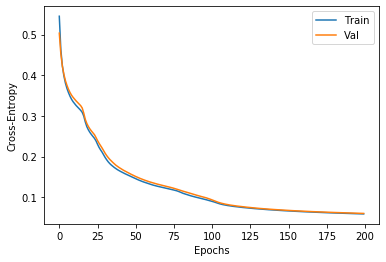

In [52]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [53]:
y_pred = model_best.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7689688715953308
F1-score [0.86939786 0.        ]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       0.00      0.00      0.00      1425

    accuracy                           0.77      6168
   macro avg       0.38      0.50      0.43      6168
weighted avg       0.59      0.77      0.67      6168



C:\Users\Gianmarco\anaconda3\envs\tfk\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
